# _Main Notebook_

## Table of Contents:

- [EDA](#eda)
  - [Data Loading](#eda_data)
  - [Preliminary checks](#eda_checks)
  - [Voting results analysis](#eda_results)
  - [Number of votes analysis](#eda_analysis)
- [Communities analysis](#communities)
  - [Setup](#communities_setup)
  - [Interaction Graph](#communites_interaction)
  - [Communities](#communities_communities)
  - [Vote Analysis](#communities_vote)
- [Content of edits analysis](#edits)
  - [Setup](#edits_setup)
  - [Statistics](#edits_statistics)
  - [Investigation of most edited pages](#edits_investigation)

In [2]:
# Imports
import pandas as pd
import sys
sys.path.append('../')
from ada2023.utils import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gzip
from itertools import combinations
from scipy.stats import pearsonr
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.formula.api as smf

# Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Data Loading <a class="anchor" id="eda_data"></a>

In [3]:
with gzip.open('../data/wiki-RfA.txt.gz', 'rt', encoding='utf-8') as f:
    blocks = f.read().strip().split('\n\n')  # Assuming each record is separated by a blank line

data = []

# Parse each block of text into a dictionary
for block in blocks:
    record = {}
    for line in block.split('\n'):
        if line:
            key, value = line.split(':', 1)  # Split on the first colon only
            record[key.strip()] = value.strip()
    data.append(record)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

#Rename the columns
df.columns = ['source', 'target', 'vote', 'result', 'year_election', 'date_vote', 'comment']

In [4]:
df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.
198272,Jiang,WhisperToMe,1,1,2003,,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....


### Preliminary checks <a class="anchor" id="eda_checks"></a>

In [5]:
#Create a new dataframe before cleaning the data
new_df = df.copy(deep=True)

##### 1 - Dive into user name source

In [6]:
#Transform the source column to string
source_cleaned_data = new_df.copy(deep=True)
source_cleaned_data['source'] = source_cleaned_data['source'].astype(str)

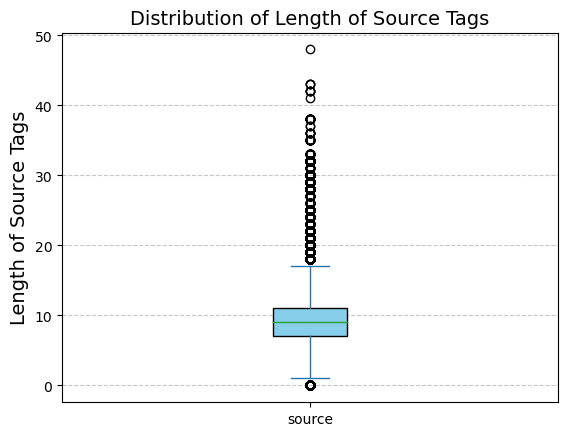

In [7]:
#Look at the distribution of the length of the source tags with a box plot
ax = source_cleaned_data['source'].str.len().plot(kind='box', patch_artist=True, 
                                                  boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Source Tags', fontsize=14)
ax.set_ylabel('Length of Source Tags', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [8]:
#Look at the number of unique source users
unique_voters = source_cleaned_data['source'].nunique()
print(f'The number of unique voters is {unique_voters}')

#Look at the number of null values for the source
nan_source = source_cleaned_data[source_cleaned_data.source == '']['source'].count()
print(f'The number of voters without tags is {nan_source}')

The number of unique voters is 10417
The number of voters without tags is 1661


While examining the outliers in relation to their source tags:

It's observed that outliers possessing source tags longer than 25 characters typically do not present specific issues.
A significant portion of these outliers are identified to have empty source tag lengths. Consequently, we've opted to exclude votes linked with empty source tags. This decision aligns with our objective to utilize the data for community building and to track user interactions. Allowing votes from empty source tags might skew our community analysis, potentially leading to an imbalance where certain users' votes are disproportionately influential compared to others.

In [9]:
#Remove the rows with votes associated to empty source 
source_cleaned_data = source_cleaned_data[source_cleaned_data.source != '']

In [10]:
#Now we look at the other outliers, votes with user tags of length greater than 200
source_cleaned_data[source_cleaned_data.source.str.len() > 20].source.unique()

array(['Pharaoh of the Wizards', "Useight's Public Sock",
       'Brambleberry of RiverClan', 'Sir Nicholas de Mimsy-Porpington',
       'Hullaballoo Wolfowitz', 'The Blade of the Northern Lights',
       'Gareth Griffith-Jones', 'Santa Claus of the Future',
       'You Can Act Like A Man', 'Future Perfect at Sunrise',
       'Lothar von Richthofen', 'GMolewaterdelaRiveBox',
       "Chase me ladies, I'm the Cavalry",
       'Short Brigade Harvester Boris', 'Rannpháirtí anaithnid',
       'Alessandra Napolitano', "Floquenstein's monster",
       'Thine Antique Pen (public)',
       'Department of Redundancy Department', 'Regent of the Seatopians',
       'Catfish Jim and the soapdish', 'Who Am I Why Am I Here',
       'ResidentAnthropologist', 'Physics is all gnomes',
       'DisillusionedBitterAndKnackered', 'PrincessWortheverything',
       'Planetary Chaos Redux', 'The most interesting man in the world',
       'Another Type of Zombie', 'SomeDudeWithAUserName',
       'The High Fin S

Usernames appear accurate and suitable for user tags, and thus do not require removal.


##### 2 - Dive into target user name

In [11]:
#Make deep copy before cleaning for target
target_cleaned_data = source_cleaned_data.copy(deep=True)

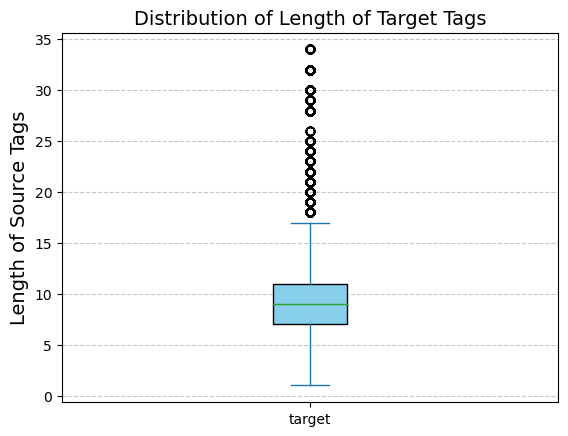

In [12]:
#Look at the distribution of the length of the target tags with a box plot
ax = target_cleaned_data['target'].str.len().plot(kind='box', patch_artist=True, 
                                                  boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Target Tags', fontsize=14)
ax.set_ylabel('Length of Source Tags', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [13]:
#Look at the number of unique target users
unique_electives = target_cleaned_data['target'].nunique()
print(f'The number of unique users running for election is {unique_electives}')

#Look at the number of null values for the source
nan_target = target_cleaned_data[target_cleaned_data.target == '']['target'].count()
print(f'The number of nan values for the target is {nan_target}')

The number of unique users running for election is 3491
The number of nan values for the target is 0


In [14]:
new_df[new_df.target.str.len() > 20].target.unique()

array(['Catfish Jim and the soapdish', 'Rannpháirtí anaithnid',
       'The Blade of the Northern Lights', 'Who Am I Why Am I Here',
       'Marcus Aurelius Antoninus', 'PopMusicWillNeverBeLowBrow',
       'RandomStringOfCharacters', 'The High Fin Sperm Whale',
       'The Thing That Should Not Be', 'Wiki Greek Basketball',
       'Backslash Forwardslash', 'Alexander.hugh.george',
       'I Seek To Help & Repair!', 'Raiku Lucifer Samiyaza',
       'The Black Rabbit of Inlé', 'crimsonterminator1000',
       'How do you turn this on', 'Imperial Star Destroyer',
       'Inferno, Lord of Penguins', 'Joseph Solis in Australia',
       'Jupiter Optimus Maximus', "Milk's Favorite Cookie",
       "Sock's Favorite Puppet", 'The Great Editor In Chief',
       'WeBuriedOurSecretsInTheGarden',
       "Chase me ladies, I'm the Cavalry", 'Faithlessthewonderboy',
       'Jaranda (reconfirmation)', 'A Raider Like Indiana',
       'Ineversigninsodonotmessageme', 'SpecialAgentUncleTito',
       "The Rav

Usernames appear accurate and suitable for user tags, and thus do not require removal.

##### 3 - Check the date and time of votes :

In [15]:
date_cleaned_data = target_cleaned_data.copy(deep=True)

In [16]:
# Define a function to extract date components
def extract_date_components(date_str):
    try:
        # Split the date string by the comma and space to separate time and date parts
        time_part, date_part = date_str.split(', ')
        # Split the time part by the colon to separate hours and minutes
        hour, minute = time_part.split(':')
        # Split the date part by space to separate day, month, and year
        day, month, year = date_part.split(' ')
        
        return pd.Series({
            "hour": hour,
            "minute": minute,
            "day": day,
            "month": month,
            "year_vote": year
        })
    except ValueError:
        # If there is a ValueError, return None for each component
        return pd.Series({
            "hour": None,
            "minute": None,
            "day": None,
            "month": None,
            "year_vote": None
        })

# Apply the function to each row in the 'date' column
date_components = date_cleaned_data['date_vote'].apply(extract_date_components)

# Concatenate the new DataFrame with the original one (if needed)
date_cleaned_data = pd.concat([date_cleaned_data, date_components], axis=1)

date_cleaned_data

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,Sep,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,Nov,2003
198272,Jiang,WhisperToMe,1,1,2003,,Support. --,None,None,None,None,None
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....,05,38,5,Dec,2003


In [17]:
#Look at the proportion of rows with missing date_vote
non_date_votes = date_cleaned_data[date_cleaned_data.date_vote == ''].date_vote.count()
total_count = date_cleaned_data.date_vote.count()
print(f'The number of votes for which the date is missing or incorrect is {non_date_votes}')
print(f'This represents {(non_date_votes/total_count)*100:.2f}% of the data.')

The number of votes for which the date is missing or incorrect is 7706
This represents 3.92% of the data.


In [18]:
#Remove the rows with missing date_vote
date_cleaned_data = date_cleaned_data[date_cleaned_data.date_vote != '']

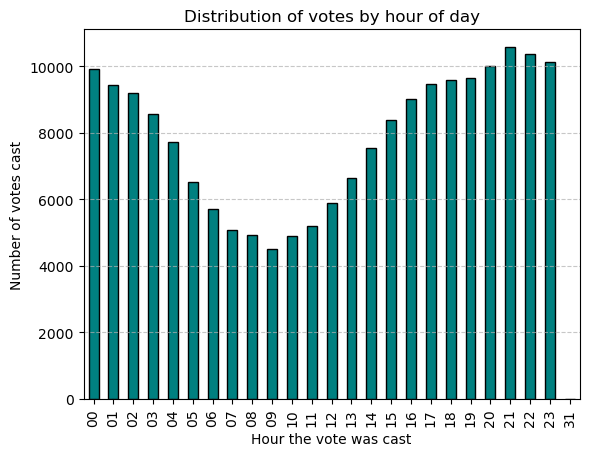

In [19]:
#Look at the distribution for the values of the hour with histogram
date_cleaned_data['hour'].value_counts().sort_index().plot(kind='bar' , color = 'teal' ,  edgecolor='black')
plt.xlabel('Hour the vote was cast')
plt.ylabel('Number of votes cast')
# Set a grid for easier reference to the quantities
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Distribution of votes by hour of day')
plt.show()

In [20]:
#Proportion of rows with the hour value as 31
ratio_of_31 = date_cleaned_data[date_cleaned_data.hour == "31"]["hour"].count()/date_cleaned_data["hour"].count()
print(f'The proportion of rows with the hour value as 31 is {ratio_of_31}')

The proportion of rows with the hour value as 31 is 5.293582061109111e-06


In this dataset, there are a small fraction of votes occurring at the 31st hour, which is not a valid time. Given that the number of occurrences is negligible, we have chosen to exclude this data point from the dataframe. This removal is unlikely to affect the overall analysis of the dataset due to its minimal incidence.

In [21]:
#Remove from the dataframe the rows with the value of the hour as 31
date_cleaned_data = date_cleaned_data[date_cleaned_data['hour'] != '31']

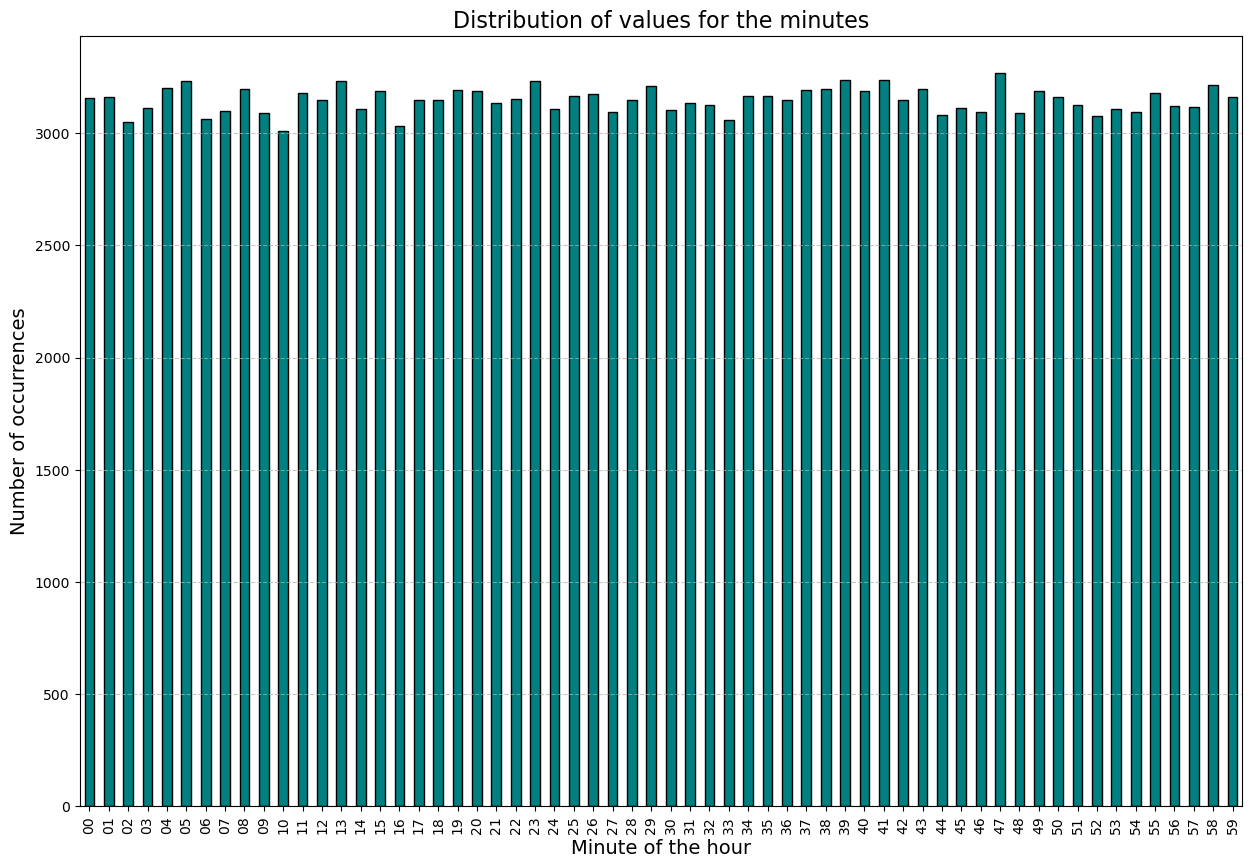

In [22]:
# Set the figure size for better visibility
plt.figure(figsize=(15, 10))

ax = date_cleaned_data['minute'].value_counts().sort_index().plot(kind='bar', color='teal', edgecolor='black')

ax.set_xlabel('Minute of the hour', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the minutes', fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

The minute values appear to be in order, and their distribution is evenly spread, which aligns with expectations.



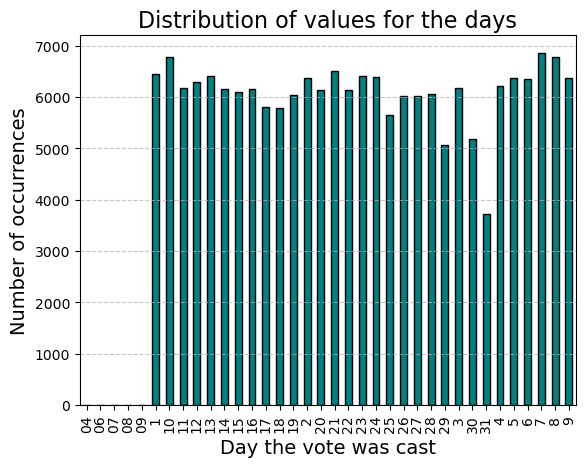

In [23]:
#Look at the distribution of the values for the days with histogram and order the values

ax = date_cleaned_data['day'].value_counts().sort_index().plot(kind='bar' ,  color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Day the vote was cast', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the days', fontsize=16)

plt.show()

The values for the day also seem to be correct.



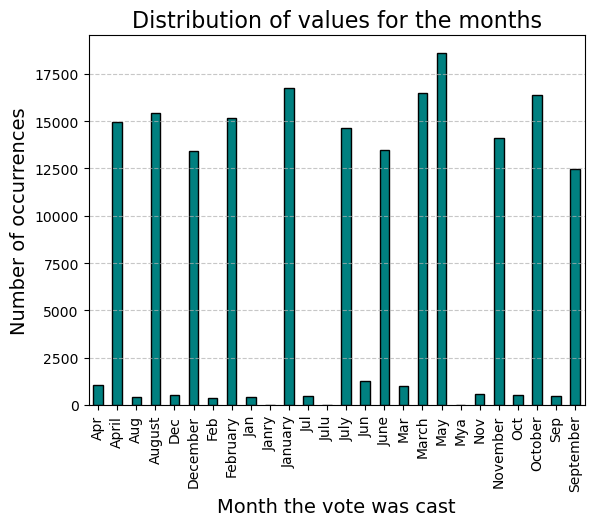

In [24]:
#Look at the distribution of the values for the months with histogram and order the values
ax = date_cleaned_data['month'].value_counts().sort_index().plot(kind='bar' , color='teal', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Month the vote was cast', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of values for the months', fontsize=16)

plt.show()

The dataset displays variations in the representation of specific months. For instance, the month of July is listed as 'Jul,' 'Julu,' and 'July'; similarly, October is noted as 'Oct' and 'October.'

In [25]:
#Map the values of the months to the full name of the month
month_map = { 
    "Apr" : "April",
    "April" : "April",
    "Aug" : "August",
    "August" : "August",
    "Dec" : "December",
    "December" : "December",
    "Feb" : "February",
    "February" : "February",
    "Jan" : "January",
    "Janry" : "January",
    "January" : "January",
    "Jul" : "July",
    "Julu" : "July",
    "July" : "July",
    "Jun" : "June",
    "June" : "June",
    "Mar" : "March",
    "March" : "March",
    "May" : "May",
    "Mya" : "May",
    "Nov" : "November",
    "November" : "November",
    "Oct" : "October",
    "October" : "October",
    "Sep" : "September",
    "September" : "September"
}

def correction_month (month) : 
    return month_map.get(month, month)

date_cleaned_data['month'] = date_cleaned_data['month'].apply(correction_month)
date_cleaned_data

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198267,Hephaestos,Ugen64,1,1,2003,"16:05, 6 Dec 2003",Also support; seems like a good contributor. -,16,05,6,December,2003
198269,Cyan,Vancouverguy,1,1,2003,"02:13, 31 Aug 2003",Support. --,02,13,31,August,2003
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,September,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,November,2003


The values for the years seems also to be ok.



In [26]:
date_cleaned_data['date_vote'] = pd.to_datetime(date_cleaned_data['day'].astype(str) + ' ' +
                            date_cleaned_data['month'].astype(str) + ' ' +
                            date_cleaned_data['year_vote'].astype(str) + ' ' +
                            date_cleaned_data['hour'].astype(str) + ':' +
                            date_cleaned_data['minute'].astype(str),
                            format='%d %B %Y %H:%M' , errors = 'coerce')

date_cleaned_data.drop(['hour', 'minute', 'day', 'month', 'year_vote'], axis=1, inplace=True)
date_cleaned_data

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198267,Hephaestos,Ugen64,1,1,2003,2003-12-06 16:05:00,Also support; seems like a good contributor. -
198269,Cyan,Vancouverguy,1,1,2003,2003-08-31 02:13:00,Support. --
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.


##### 4 - Dive into the year_election values

In [27]:
year_elections_cleaned_data = date_cleaned_data.copy(deep=True)

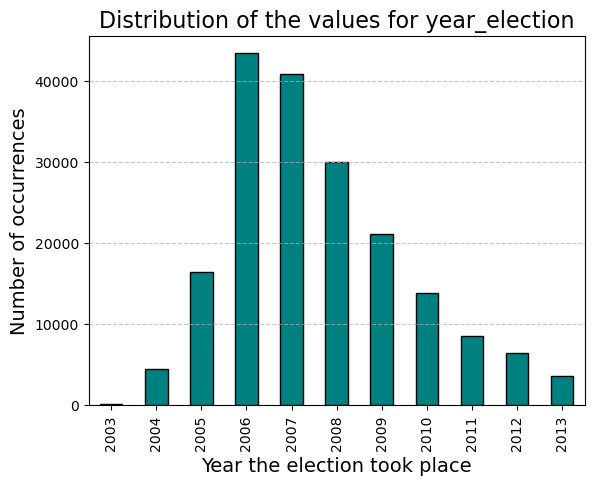

In [28]:
#Look at the distribution of the values for year_election
year_elections_cleaned_data['year_election'] = year_elections_cleaned_data['year_election'].astype(int)


ax = year_elections_cleaned_data['year_election'].value_counts().sort_index().plot(kind='bar' , color='teal', 
                                                                                   edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Year the election took place', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for year_election', fontsize=16)

plt.show()

##### 5 - Dive into the vote and results values


In [29]:
vote_results_data_cleaned = year_elections_cleaned_data.copy(deep=True)

count    188907.000000
mean          0.522331
std           0.815787
min          -1.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: vote, dtype: float64


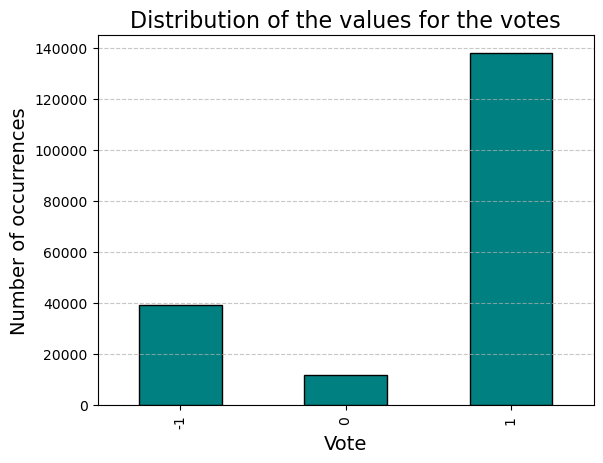

In [30]:
#Look at the distribution of the values for the vote
vote_results_data_cleaned['vote'] = vote_results_data_cleaned['vote'].astype(int)
vote_results_data_cleaned['result'] = vote_results_data_cleaned['result'].astype(int)

print(vote_results_data_cleaned['vote'].describe())
ax = vote_results_data_cleaned['vote'].value_counts().sort_index().plot(kind='bar' , color='teal', 
                                                                        edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Vote', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for the votes', fontsize=16)

plt.show()

In [31]:
value_perc_vote = vote_results_data_cleaned['vote'].value_counts(normalize=True) * 100

# Print the percentages
print("Percentage of Each Unique Value in vote:")
print(value_perc_vote)

Percentage of Each Unique Value in vote:
vote
 1    73.033292
-1    20.800182
 0     6.166526
Name: proportion, dtype: float64


count    188907.000000
mean          0.240642
std           0.970616
min          -1.000000
25%          -1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: result, dtype: float64


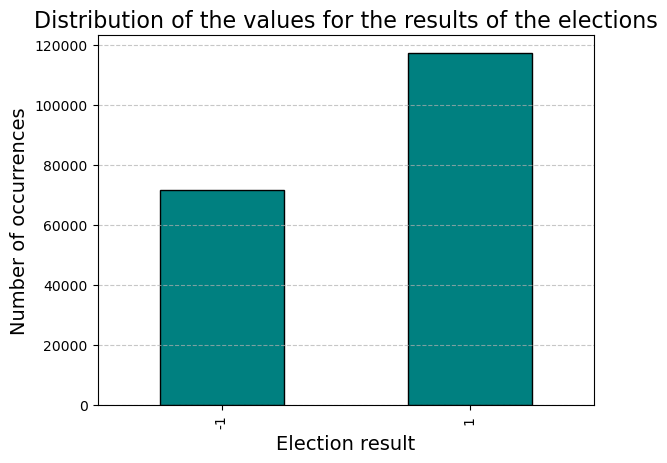

In [32]:
#Look at the distribution of the values for the result
print(vote_results_data_cleaned['result'].describe())
ax = vote_results_data_cleaned['result'].value_counts().sort_index().plot(kind='bar' , color='teal', 
                                                                          edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Election result', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)
ax.set_title('Distribution of the values for the results of the elections', fontsize=16)

plt.show()
plt.show()

In [33]:
value_perc_result = vote_results_data_cleaned['result'].value_counts(normalize=True) * 100

# Print the percentages
print("Percentage of Each Unique Value in result:")
print(value_perc_result)

Percentage of Each Unique Value in result:
result
 1    62.032111
-1    37.967889
Name: proportion, dtype: float64


##### 6 - Dive into comments

The percentage of empty comments is 2.31%%


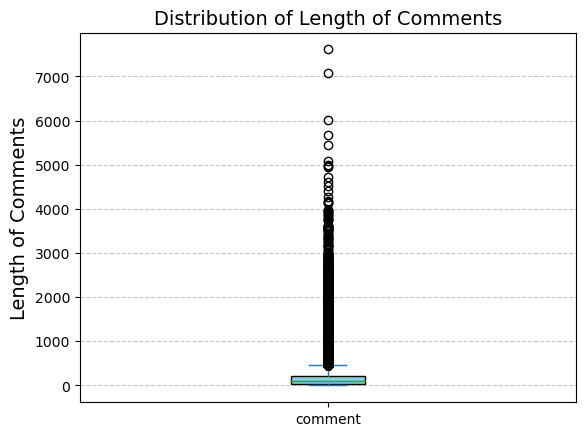

In [34]:
#Look at the proportion of empty comments
nb_empty_com = vote_results_data_cleaned[vote_results_data_cleaned.comment == ""]["comment"].count()
ratio_empty_com = nb_empty_com/vote_results_data_cleaned["comment"].count()
print(f'The percentage of empty comments is {ratio_empty_com:.2%}%')

#Look at the disribution of the length of the comments
ax = vote_results_data_cleaned['comment'].str.len().plot(kind='box', patch_artist=True, 
                                                         boxprops=dict(facecolor='skyblue'))
ax.set_title('Distribution of Length of Comments', fontsize=14)
ax.set_ylabel('Length of Comments', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [35]:
cleaned_df = vote_results_data_cleaned.copy(deep=True)

#Store the cleaned dataframe in a csv file
cleaned_df.to_csv('../data/wiki-RfA-cleaned.csv', index=False)

### Voting results analysis <a class="anchor" id="eda_results"></a>

In [36]:
#Import the cleaned dataframe
analysis_df = pd.read_csv('../data/wiki-RfA-cleaned.csv')

In [37]:
analysis_df['date_vote'] = pd.to_datetime(analysis_df['date_vote'])

##### 1 - User behavior

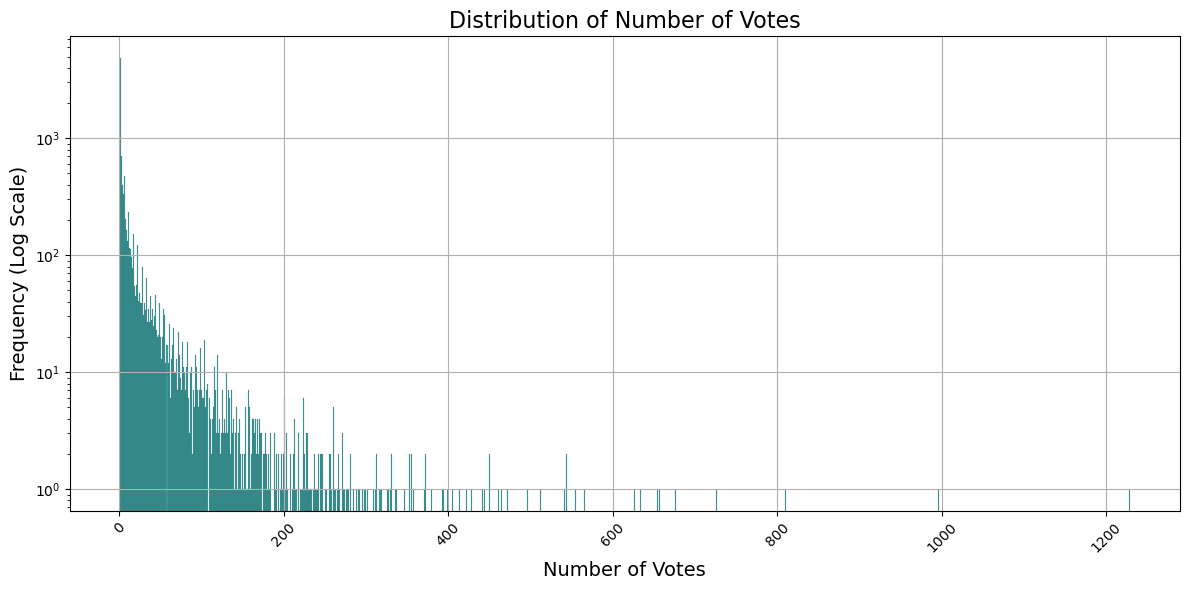

In [38]:
#First we plot the distribution of the number of votes per user
grouped_per_user = analysis_df.groupby('source').apply(lambda x : pd.Series({
    'number_of_votes' : len(x['target'])})).reset_index()

plt.figure(figsize=(12, 6))

ax = sns.histplot(grouped_per_user['number_of_votes'], color='teal', log=True, bins=1000, edgecolor='black')

ax.set_title('Distribution of Number of Votes', fontsize=16)  
ax.set_xlabel('Number of Votes', fontsize=14)  
ax.set_ylabel('Frequency (Log Scale)', fontsize=14) 
ax.grid(True) 
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

We can see a classic long-tail distribution of voter activity, indicative of a pattern where a small number of individuals account for a disproportionately large number of votes, while the vast majority participate minimally. The steep decline and subsequent long tail to the right suggest that the community has a few highly engaged users, a common trait in voluntary, community-driven platforms. This could imply that engagement initiatives might focus on the more active users to leverage their influence, or conversely, on the less active majority to increase overall participation.

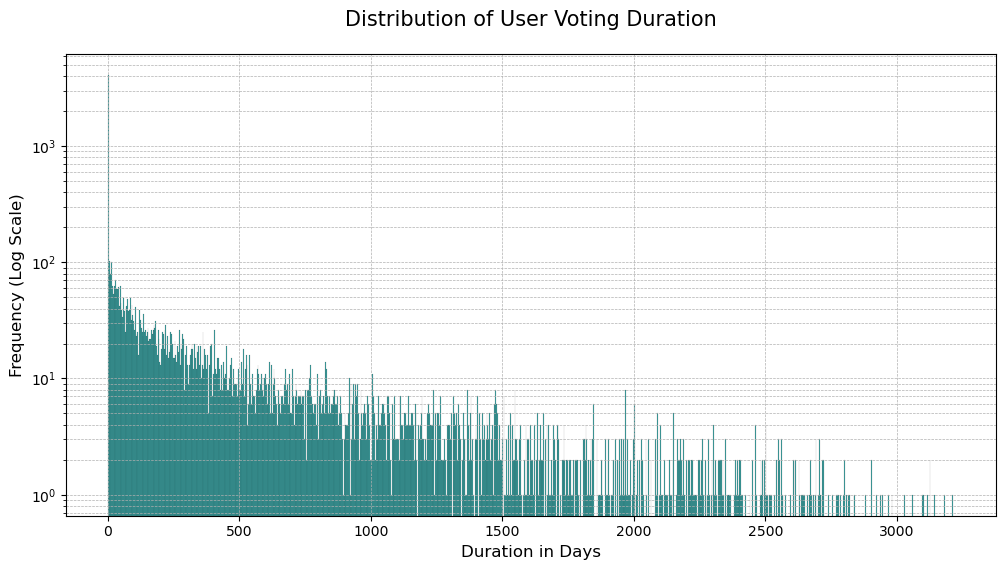

In [39]:
date_analysis = analysis_df.groupby('source').apply(lambda x : pd.Series({
    'sequence_of_votes' : x['date_vote'].values})).reset_index()

def calculation_duration (dates) : 
     
    sorted_dates = sorted(dates)
    return (sorted_dates[-1] - sorted_dates[0])

date_analysis['duration'] = date_analysis['sequence_of_votes'].apply(calculation_duration)

#Look into the distribution of the duration of the sequence of votes
plt.figure(figsize=(12, 6))

ax = sns.histplot(date_analysis['duration'].dt.days, color='teal', log =True,bins = 1000,  edgecolor='black')

ax.set_title('Distribution of User Voting Duration', fontsize=15, pad=20)
ax.set_xlabel('Duration in Days', fontsize=12)
ax.set_ylabel('Frequency (Log Scale)', fontsize=12)
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

The histogram depicting the duration between users' first and last votes confirms the conclusion form the previous plot : most users engage in a short burst of activity, casting votes for a brief period before becoming inactive, as shown by the numerous tall bars at the plot's start. This trend aligns with the initial surge of participation seen in the previous plot, where many users voted only a few times. Conversely, the long tail in both plots points to a subset of dedicated users who not only vote more frequently but also stay active over long stretches, suggesting a core group's persistent engagement shapes the platform's voting landscape. Together, these insights reveal a pattern of engagement where a small cohort of users provides ponctual votes and others who have a really important impact.

       estimated_number_elections
count                 3468.000000
mean                     1.197809
std                      0.529571
min                      1.000000
25%                      1.000000
50%                      1.000000
75%                      1.000000
max                      7.000000


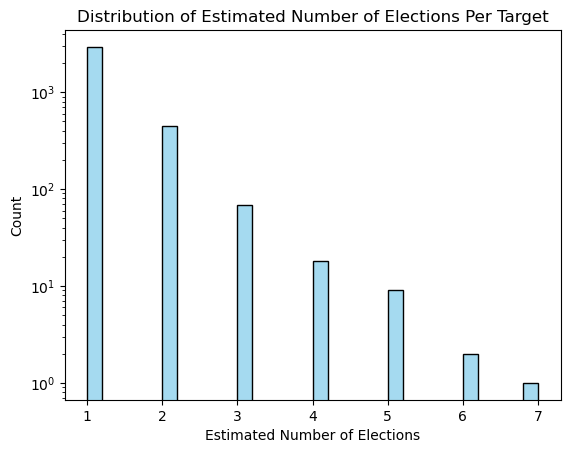

In [40]:
#Now to get an inuition about the average number of election that a user runs for
#As we know that an RfA is on average 7 days, we will set this specific time lapse as the duration of an election

def estimate_number_of_elections(group):
    # Ensure the dates are sorted
    sorted_dates = group.sort_values()
    
    # Initialize the count of elections and set the first election start date
    elections_count = 1
    election_start = sorted_dates.iloc[0]

    for date in sorted_dates[1:]:
        # If the current vote is more than a week after the election start, count a new election
        if (date - election_start).days > 7:
            elections_count += 1
            election_start = date

    return elections_count

estimated_number_elections_per_user = (analysis_df.groupby('target')['date_vote']
                                                  .apply(estimate_number_of_elections)
                                                  .reset_index()
                                                  .rename(columns={'date_vote': 'estimated_number_elections'}))

#We look at the distribution of values for the estimated number of elections
print(estimated_number_elections_per_user.describe())

#We look at the distribution of values for the estimated number of elections
sns.histplot(estimated_number_elections_per_user.estimated_number_elections, bins=30, kde=False, 
             color='skyblue', log = True)
plt.title('Distribution of Estimated Number of Elections Per Target')
plt.xlabel('Estimated Number of Elections')
plt.ylabel('Count')
plt.show()

The histogram and descriptive statistics indicate that the majority of targets in the dataset are estimated to have run for just one election, which is consistent with the data's mean and mode both being close to 1. The significant drop-off after one election suggests that it is much less common for targets to run multiple times. With over 75% of the targets estimated to have participated in only one election, there's a clear indication that repeated runs for election are rare. This aligns with the earlier plots showing that while there are a few highly active and engaged individuals, the vast majority have lower levels of activity. In this context, the repeated candidacies could be attributed to a similarly small group of individuals who are highly involved in the community, repeatedly seeking election, reflecting a pattern of engagement where a core group of users is significantly more active than the rest.

In [41]:
# Get the users who ran for election only once
ran_once = (estimated_number_elections_per_user[estimated_number_elections_per_user
                                                .estimated_number_elections == 1])

# Get the users who ran for election only once and did not get elected
not_elected_once = ran_once[~ran_once.target.isin(analysis_df[analysis_df.result == 1].target)]

number_unique_people_running = analysis_df.target.nunique()
ratio_give_up_after_one = len(not_elected_once)/number_unique_people_running
print(f'The proportion of users that give up after one election is {ratio_give_up_after_one:.2%}%')

The proportion of users that give up after one election is 39.07%%


The statistic that 39% of voters do not participate in subsequent elections if they don't succeed in their first attempt is indicative of a high dropout rate, potentially reflecting various underlying factors. This rate suggests a significant level of voter apathy or disillusionment, possibly arising from a perception that their vote lacks impact or from a general lack of sustained motivation. This statistic also poses questions about the evolving nature of voter engagement and the effectiveness of current electoral systems in sustaining voter interest and belief in the electoral process.

##### 2 - Election dynamics

In [42]:
elect_dynamics_df = analysis_df.copy(deep=True)

In [43]:
# We set an id fo each of the election following the method used before in order to compute 
# further statistics regarding the elections

# Sort the dataframe by 'target' and 'date_vote'
elect_dynamics_df.sort_values(by=['target', 'date_vote'], inplace=True)

# Initialize a counter for the global election ID
global_election_id = 0
# Initialize the last seen election date for each target
last_election_date = elect_dynamics_df.groupby('target')['date_vote'].first() - pd.Timedelta(days=8)

# Function to assign election ids
def assign_election_ids(row):
    global global_election_id
    # If the current vote date is more than 7 days after the last election date for this target
    if (row['date_vote'] - last_election_date[row['target']]).days > 7:
        global_election_id += 1
        last_election_date[row['target']] = row['date_vote']
    return global_election_id

# Apply the function to each row
elect_dynamics_df['global_election_id'] = elect_dynamics_df.apply(assign_election_ids, axis=1)

In [44]:
#Add a column corresponding the the index of the vote in the election
elect_dynamics_df['vote_index_in_election'] = elect_dynamics_df.groupby(['target', 'global_election_id']).cumcount() + 1

In [45]:
elect_dynamics_df

,source,target,vote,result,year_election,date_vote,comment,global_election_id,vote_index_in_election
124379,Dbiv,(aeropagitica),1,1,2006,2006-02-28 00:09:00,"'''Support'''. Yippee, I get to be the first!",1,1
124380,King of Hearts,(aeropagitica),1,1,2006,2006-02-28 01:11:00,"'''Support''' as nominator, of course. --",1,2
124381,Blnguyen,(aeropagitica),1,1,2006,2006-02-28 01:32:00,"'''Support''' have seen this chap around, help...",1,3
124415,ILovePlankton,(aeropagitica),-1,1,2006,2006-02-28 02:05:00,'''Oppose''' Not enough interaction with other...,1,4
124382,Zsinj,(aeropagitica),1,1,2006,2006-02-28 02:50:00,"'''Support''', even though the majority of edi...",1,5
...,...,...,...,...,...,...,...,...,...
180516,mikkalai,Ђорђе Д. Божовић,-1,-1,2005,2005-11-27 17:16:00,'''Oppose''': The person is simply unknown to ...,4154,15
180517,Sarahe,Ђорђе Д. Божовић,-1,-1,2005,2005-11-28 00:05:00,"'''Oppose''' as per jkelly, JIP and Kelly Mart...",4154,16
180518,NormanEinstein,Ђорђе Д. Божовић,-1,-1,2005,2005-11-30 15:08:00,'''Oppose''' per JIP. --,4154,17
180504,Jobe6,Ђорђе Д. Божовић,1,-1,2005,2005-11-30 23:56:00,'''Support''' reasons for oppose are somewhat ...,4154,18


In [46]:
#We compute here different statistics
elect_features_df = elect_dynamics_df.groupby(['global_election_id']).apply(lambda x : pd.Series({
    'number_of_votes' : len(x['source']), 
    'ratio_positive_votes' : x[x.vote == 1]['vote'].sum() / len(x.source), 
    'ratio_neutral_votes' : x[x.vote == 0]['vote'].sum() / len(x.source),
    'average_comment_length' : x['comment'].str.len().mean(),
    'date_last_vote' : x['date_vote'].max(),
    'result' : x['result'].max(),
    'year_election' : x['year_election'].max(),
    'target' : x['target'].unique(),
    'list_of_voters_index_vote ' : x['source'].unique(),
    
})).reset_index()

elect_features_df

,global_election_id,number_of_votes,ratio_positive_votes,ratio_neutral_votes,average_comment_length,date_last_vote,result,year_election,target,list_of_voters_index_vote
0,1,51,0.705882,0.0,109.000000,2006-03-06 22:36:00,1,2006,[(aeropagitica)],"[Dbiv, King of Hearts, Blnguyen, ILovePlankton..."
1,2,6,0.000000,0.0,278.500000,2010-09-29 20:50:00,-1,2010,[07bargem],"[Salvio giuliano, Wolfnix, Logan, Acather96, N..."
2,3,6,0.000000,0.0,275.333333,2010-05-20 00:57:00,-1,2010,[1234r00t],"[Shirik, Jarkeld, Iridescent, HJ Mitchell, Rod..."
3,4,6,1.000000,0.0,40.000000,2003-12-05 05:39:00,1,2003,[168...],"[Cyp, Maximus Rex, Cyan, Angela, Hephaestos, P..."
4,5,24,0.166667,0.0,324.833333,2008-03-19 19:55:00,-1,2008,[21655],"[Glacier Wolf, Clpo13, EJF, Keeper76, Deacon o..."
...,...,...,...,...,...,...,...,...,...,...
4149,4150,2,0.000000,0.0,353.000000,2006-06-13 06:23:00,-1,2006,[zhudyzhu],"[Grandmasterka, Kimchi.sg]"
4150,4151,14,0.785714,0.0,117.090909,2004-05-20 18:30:00,1,2004,[Ævar Arnfjörð Bjarmason],"[Viajero, 172, Finlay McWalter, Charles Matthe..."
4151,4152,68,0.544118,0.0,225.923077,2005-10-16 00:41:00,-1,2005,[Ævar Arnfjörð Bjarmason],"[Titoxd, Redwolf24, Ilyanep, Shimgray, Splash,..."
4152,4153,217,0.635945,0.0,247.189815,2012-10-09 01:42:00,-1,2012,[Σ],"[Legoktm, Riley Huntley, Barts1a, The Earwig, ..."


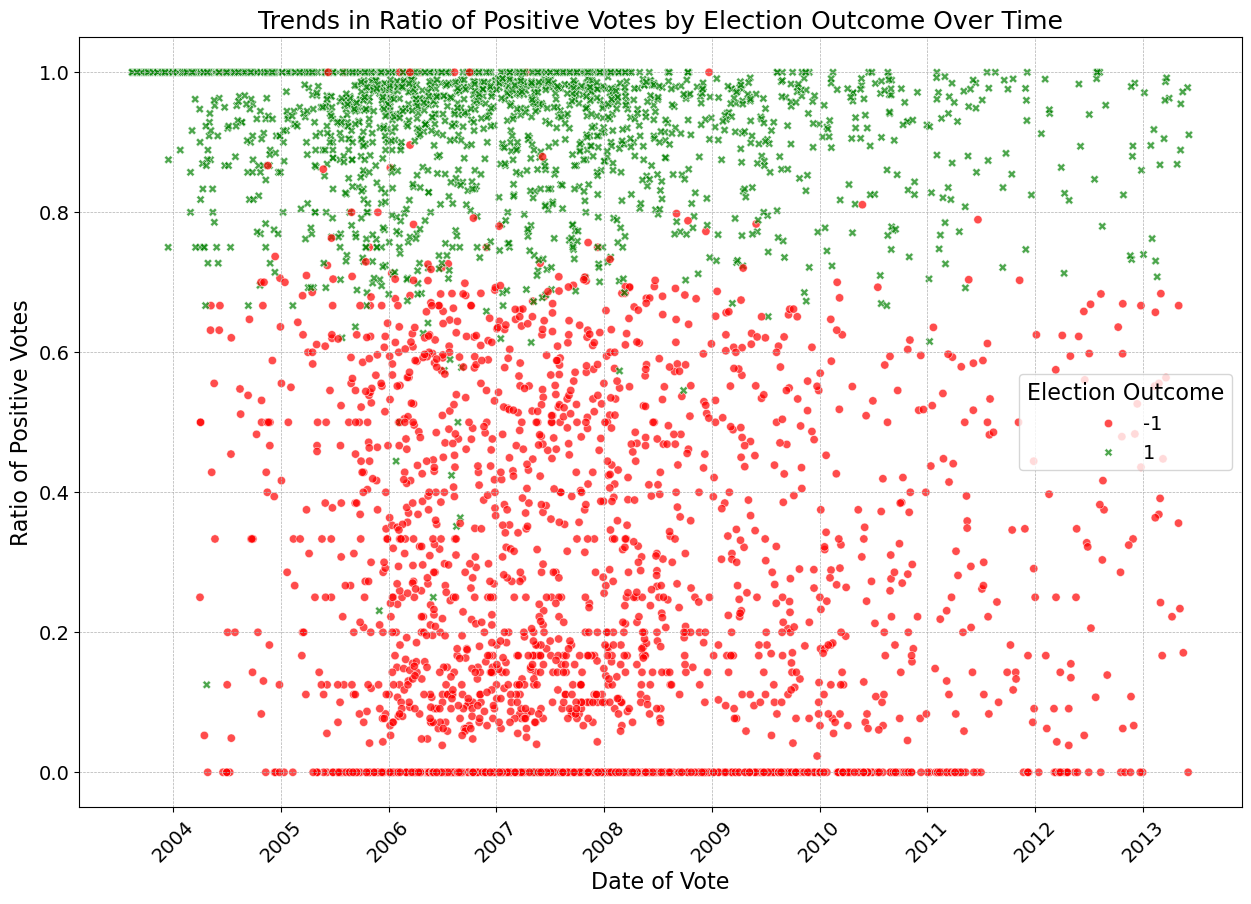

In [47]:
plt.figure(figsize=(15, 10)) 

custom_palette = {1: "green", -1: "red"}

sns.scatterplot(x='date_last_vote',
             y='ratio_positive_votes', 
             hue='result', 
             style='result', 
             data=elect_features_df,
             palette= custom_palette,
             alpha = 0.7) 

plt.title('Trends in Ratio of Positive Votes by Election Outcome Over Time', fontsize=18)
plt.xlabel('Date of Vote', fontsize=16)
plt.ylabel('Ratio of Positive Votes', fontsize=16)
plt.xticks(rotation=45, fontsize=14)  
plt.yticks(fontsize=14)
plt.legend(title='Election Outcome', fontsize=14, title_fontsize=16)
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()


The scatter plot illustrates a correlation between the ratio of positive votes and election outcomes, with a dense cluster of green dots at higher ratios indicating wins and red dots at lower ratios indicating losses. As the number of votes increases, there seems to be a trend toward more wins, shown by the prevalence of green dots in areas with a greater number of votes. Elections with a moderate ratio of positive votes show a mix of outcomes, reflecting the competitive nature of those elections. Overall, the plot suggests that while a higher number of votes is generally favorable, the ratio of positive votes is a strong indicator of success in elections, as most wins are concentrated in the region with higher positive vote ratios

Seems like there is a specific threshold for the percentage of positive votes for an election to be successfull.

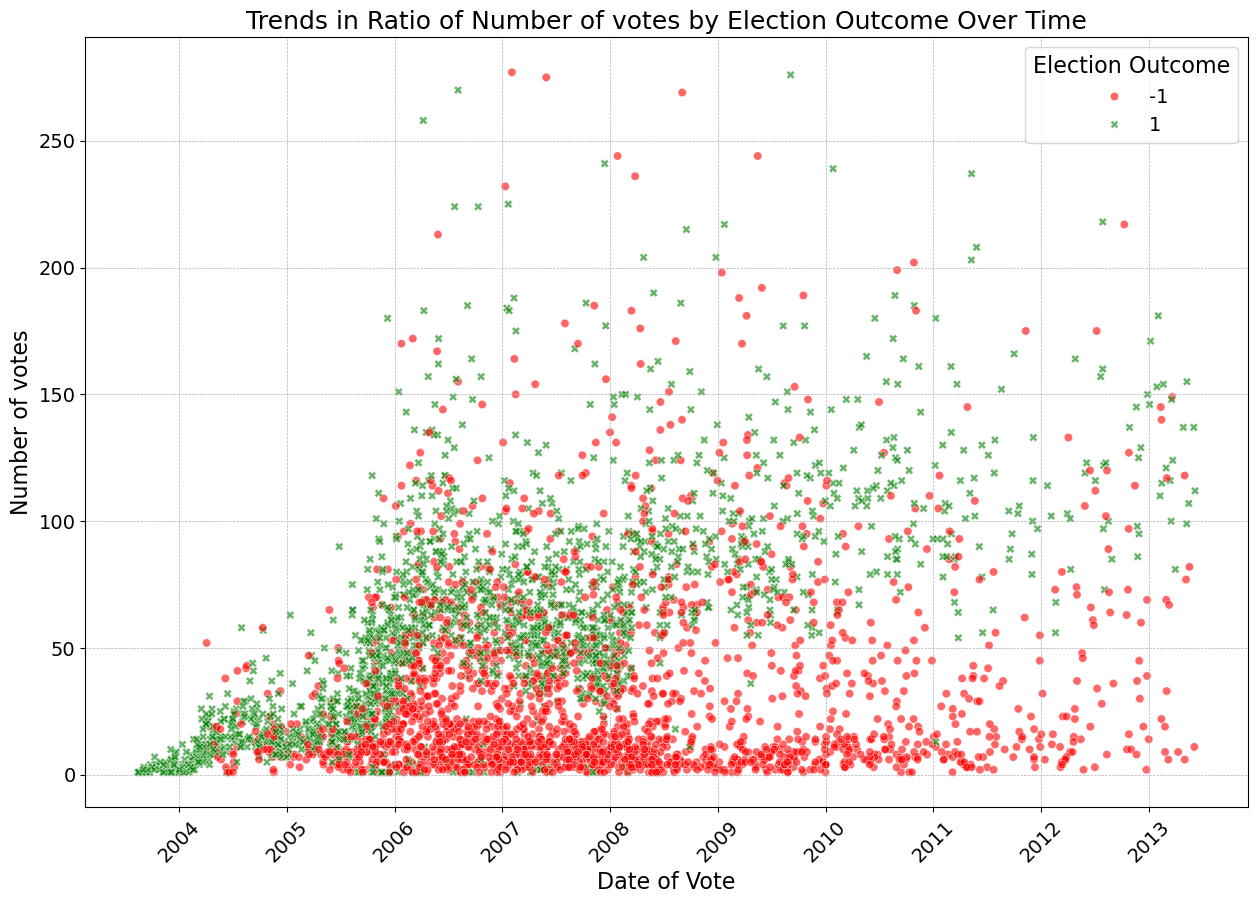

In [48]:
plt.figure(figsize=(15, 10))  

sns.scatterplot(x='date_last_vote',
             y='number_of_votes', 
             hue='result', 
             style='result', 
             data=elect_features_df,
             palette= custom_palette, 
             alpha = 0.6) 

plt.title('Trends in Ratio of Number of votes by Election Outcome Over Time', fontsize=18)
plt.xlabel('Date of Vote', fontsize=16)
plt.ylabel('Number of votes', fontsize=16)
plt.xticks(rotation=45, fontsize=14)  
plt.yticks(fontsize=14)
plt.legend(title='Election Outcome', fontsize=14, title_fontsize=16)
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

The plot suggests that the -1 outcome is commonly associated with a lower number of votes, while the 1 outcome shows greater variability with several outliers indicating exceptionally high vote counts. Despite the presence of both outcomes throughout the time range, there's no apparent temporal trend in voting patterns. We will further analyse this below by loooking at each year and try to detect wether we have further insights. 

We will use below statistical measure to determine the real relation between the different variables.

In [49]:
#We compute the correlation between the ratio of positive votes and the outcome of the election
stats.pearsonr(elect_features_df['ratio_positive_votes'], elect_features_df['result'])

PearsonRResult(statistic=0.8687042654781557, pvalue=0.0)

In [50]:
#We compute the correlation between the number of votes and the outcome of the election
stats.pearsonr(elect_features_df['number_of_votes'], elect_features_df['result'])

PearsonRResult(statistic=0.31818316678781944, pvalue=2.254501708865548e-98)

In [51]:
regression_df = elect_features_df.copy(deep=True)
regression_df['result'] = regression_df['result'].replace({-1 : 0})
mod = smf.logit(formula='result ~  (year_election) + number_of_votes + ratio_positive_votes + \
                          + ratio_positive_votes + average_comment_length' , data=regression_df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.116421
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 4149
Model:                          Logit   Df Residuals:                     4144
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.8318
Time:                        15:50:31   Log-Likelihood:                -483.03
converged:                       True   LL-Null:                       -2871.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 19.7699    114.721      0.172      0.863    -205.078     

Model Fit: The R-squared value is 0.8318, which is high, suggesting that the model fits the data well.

Significance: The LLR (likelihood ratio test) p-value is less than 0.05, indicating that the model as a whole is statistically significant compared to the null model.

Regarding the different coefficients :

The ratio_positive_votes coefficient is significant (p < 0.05) and positive, indicating that as the ratio of positive votes increases, the log-odds of winning the election (result=1) significantly increase.
The year_election, number_of_votes, and average_comment_length coefficients are not statistically significant (p > 0.05), implying that these variables do not have a significant impact on the log-odds of the election outcome in the presence of other variables.
Intercept: The intercept is also not significant, which is not typically a concern as it simply sets the baseline log-odds of the outcome when all predictors are at zero.

In summary, the model strongly suggests that the ratio of positive votes is a key predictor of election outcomes, while other variables like the year of the election, the number of votes, and the average comment length do not show a significant relationship in this logistic regression model. The presence of quasi-separation suggests that while the model fits the current data well, it might not generalize well to new data.

### Number of votes analysis <a class="anchor" id="eda_analysis"></a>

In [52]:
elect_features_df['year_election'].unique().sort()

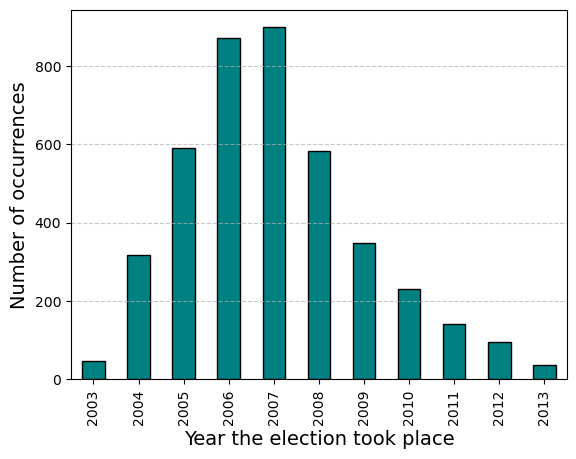

In [53]:
#Plot the distribution of the number of elections per year
ax = elect_features_df['year_election'].value_counts().sort_index().plot(kind='bar' , 
                                                                         color='teal', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('Year the election took place', fontsize=14)
ax.set_ylabel('Number of occurrences', fontsize=14)

plt.show()

We clearly have an imbalance number of elections through the years. We will analyse the trend over time of votting patterns, wether in specific years we had more elections with positiv outcome. 

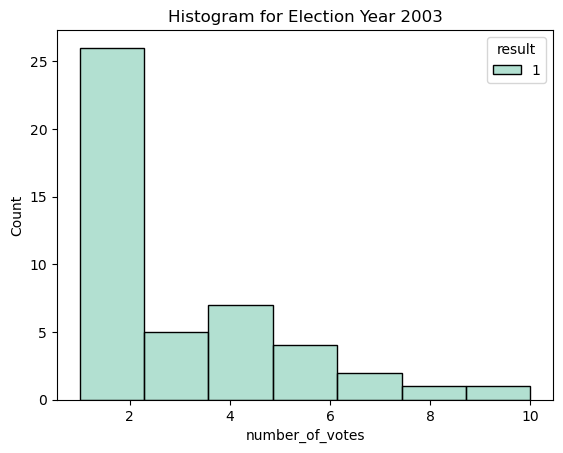

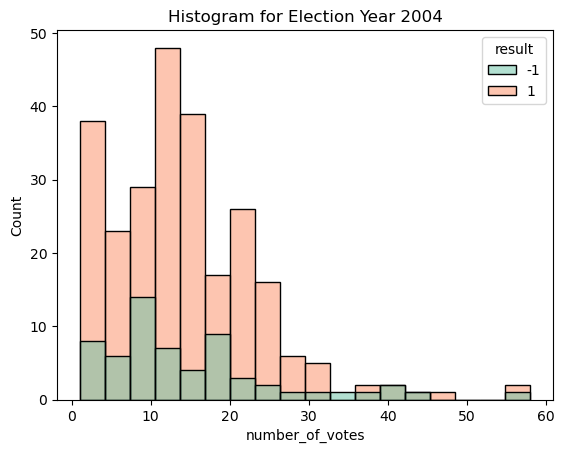

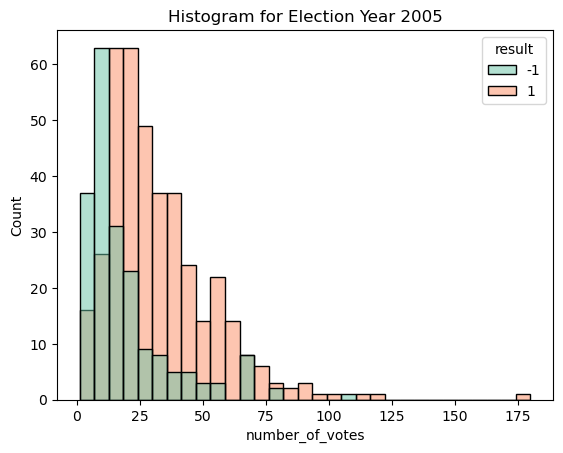

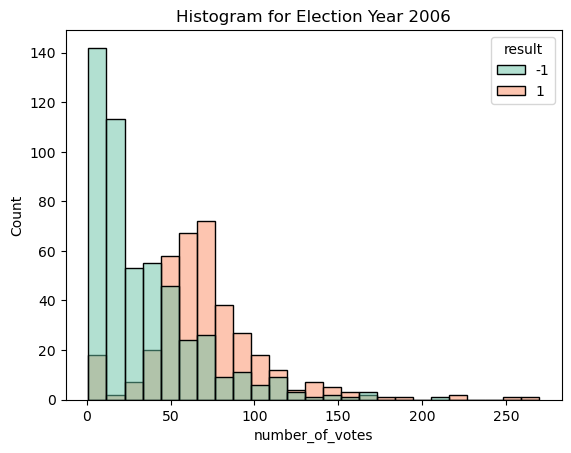

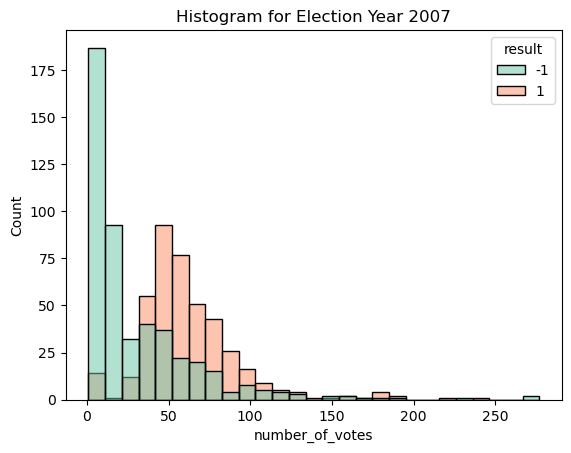

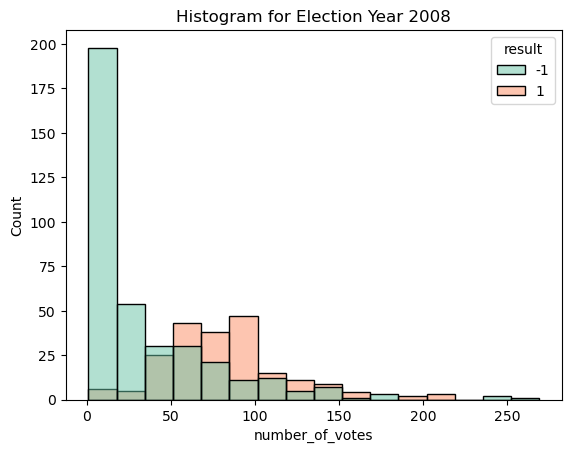

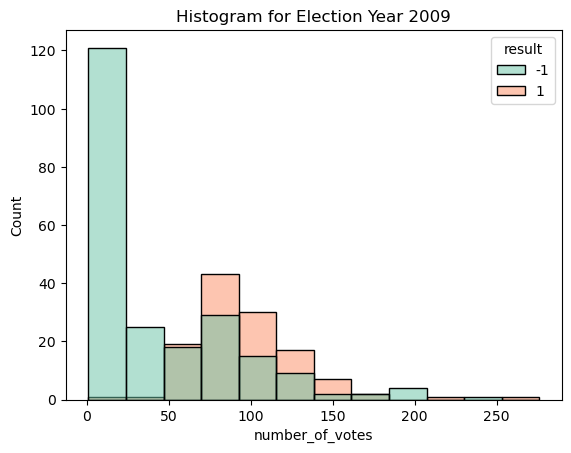

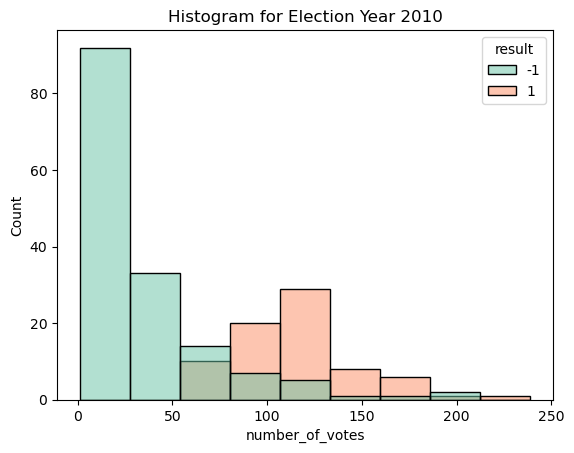

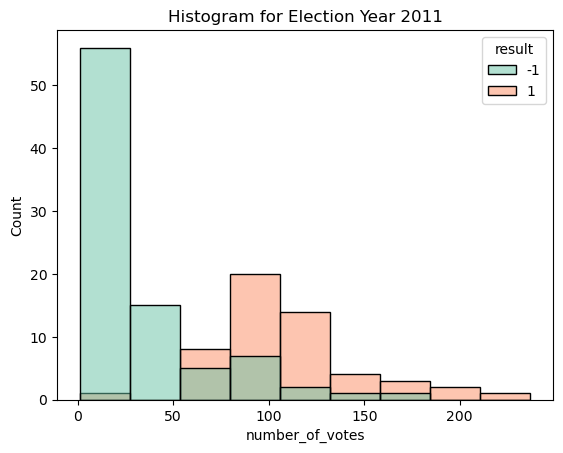

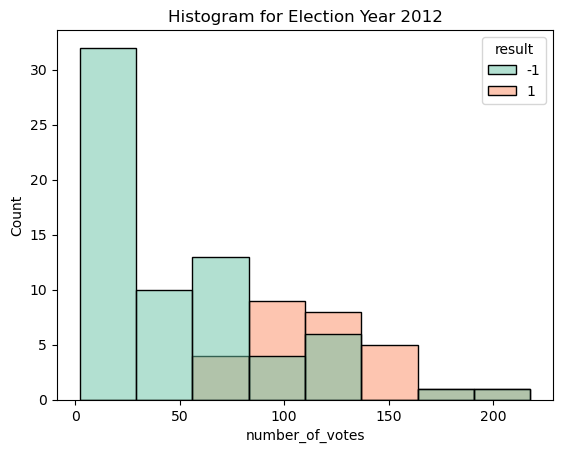

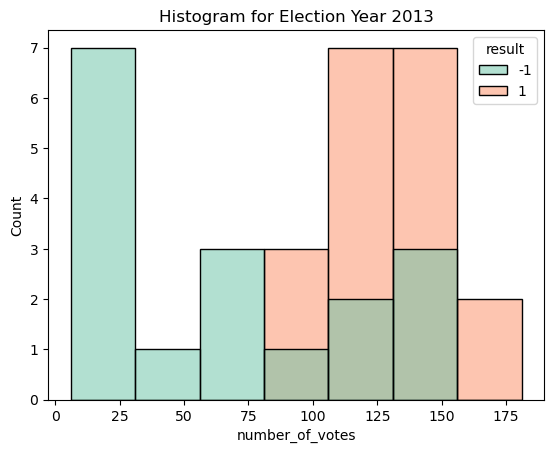

In [54]:
# Assuming 'election_year' is of type int
for year in sorted(elect_features_df['year_election'].unique()):
    data_subset = elect_features_df[elect_features_df['year_election'] == year]
    
    sns.histplot(x='number_of_votes', data=data_subset, hue='result', log_scale=(False, False), 
                 color = 'skyblue', edgecolor='black' , palette= 'Set2')
    plt.title(f'Histogram for Election Year {int(year)}')
    plt.show()

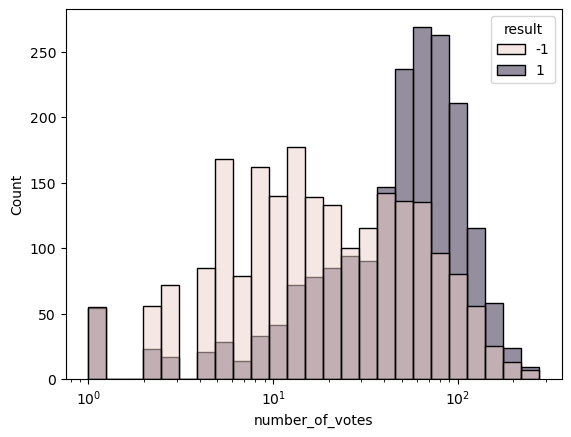

In [55]:
sns.histplot(x = 'number_of_votes', data = elect_features_df , hue = 'result', log_scale= (True, False))
plt.show()

In [56]:
print(new_df.groupby(["target", "result"])["source"].count().median())
print(new_df.groupby(["target", "result"])["source"].count().mean())

42.0
53.11411733190464


We have a specific pattern that is quite common every years regarding the elections. We have a high proportion of elections that have a low number of votes and those elections most of the time end with a bad outcome (election being -1). The election that end with a positive outcome tend to rely on an important number of votes.

# Communities Analysis <a class="anchor" id="communities"></a>

### Setup <a class="anchor" id="communities_setup"></a>

We process the Wikipedia Request for Adminship (RfA) dataset into a dataframe. We are using a [Wikipedia edit history dataset](https://snap.stanford.edu/data/wiki-meta.html) containing edit up to january 2008. Therefore we filter votes that aren't present in this timeframe.

In [57]:
df = pd.read_csv("../data/wiki-RfA-cleaned.csv")

# We filter out all the votations after 2008 as we do not have the edits for those dates
df = df[df.year_election < 2009]

#Set of users that are present in the adminship dataset
admin_set = set(df['source'].to_list() + df['target'].to_list())

In [58]:
print(f"Number of users present in the adminship dataset : {len(admin_set)}")

Number of users present in the adminship dataset : 8494


### Interaction Graph <a class="anchor" id="communities_interaction"></a>

We consider an interaction between two users to be an edit from user A in the user talk page of user B. User talk page ["normal use is for messages from, and discussion with, other editors"](https://en.wikipedia.org/wiki/Wikipedia:User_pages). We filtered edits to keep only interactions from users that where present in the RfA dataset. Using those interactions we created an undirected graph where the weight is the number of interaction between the two users and each node is a user.

In [59]:
G = create_interaction_graph()

In [60]:
print(f"Number of nodes (users) in the graph : {len(G)}")
print(f"Number of users in the RfA dataset : {len(admin_set)}")
print(f"Percentage of users in the graph : {(len(G)/len(admin_set)):.2%}")

Number of nodes (users) in the graph : 6491
Number of users in the RfA dataset : 8494
Percentage of users in the graph : 76.42%


In [61]:
interactions_df = df.copy(deep=True)
interactions_df['vote'] = interactions_df['vote'].astype(int)

def get_interaction_weight(graph, node1, node2):
    try:
        # Retrieve the weight attribute of the edge between node1 and node2
        weight = graph[node1][node2].get('weight', 0)
    except KeyError:
        # If there's no edge between node1 and node2, the interaction count is 0
        weight = 0
    return weight

# Apply the function to each row of the DataFrame
interactions_df['interaction_count'] = interactions_df.apply(lambda row: get_interaction_weight(G, row['source'], row['target']), axis=1)

interactions_df

,source,target,vote,result,year_election,date_vote,comment,interaction_count
53484,Acalamari,^demon,1,1,2008,2008-02-15 20:19:00,"Was a great admin before, and will be again. E...",0
53485,Qst,^demon,1,1,2008,2008-02-15 20:29:00,'''Support'''. What Acalamari said ;).,0
53486,Mr.Z-man,^demon,1,1,2008,2008-02-15 20:32:00,"Of course. <font face=""Broadway"">",2
53487,Rjd0060,^demon,1,1,2008,2008-02-15 20:34:00,Why not give them back? -,0
53488,Jj137,^demon,1,1,2008,2008-02-15 20:58:00,'''Support''' - definitely. &nbsp; ''',0
...,...,...,...,...,...,...,...,...
188902,Hephaestos,Ugen64,1,1,2003,2003-12-06 16:05:00,Also support; seems like a good contributor. -,4
188903,Cyan,Vancouverguy,1,1,2003,2003-08-31 02:13:00,Support. --,0
188904,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support,0
188905,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.,2


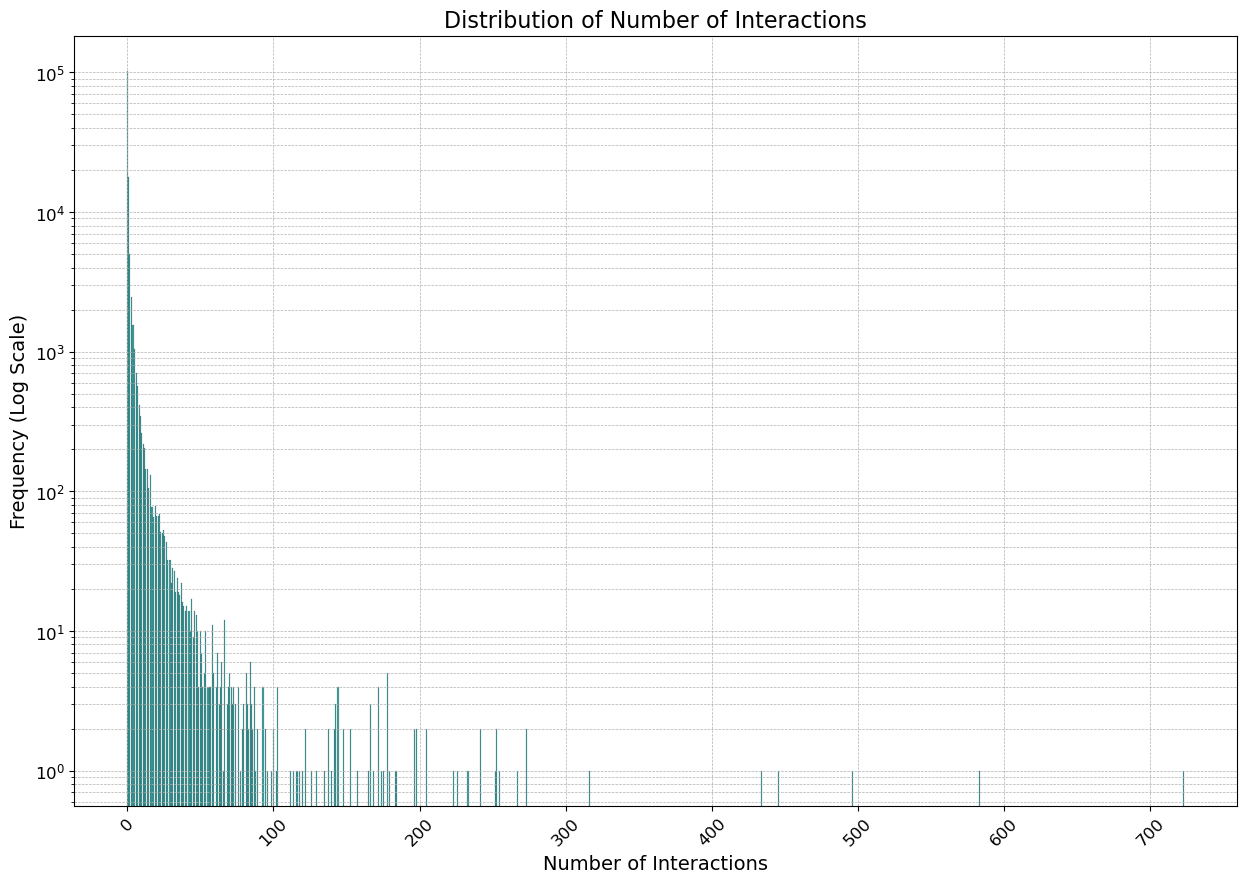

In [62]:
#Look at the distribution of the number of interactions per election
plt.figure(figsize=(15, 10))

ax = sns.histplot(interactions_df['interaction_count'], color='teal', log=True, bins=1000, edgecolor='black')

ax.set_title('Distribution of Number of Interactions', fontsize=16)
ax.set_xlabel('Number of Interactions', fontsize=14)
ax.set_ylabel('Frequency (Log Scale)', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

We will explore the influence of user interactions, as captured in our interaction graph, on their participation and choices in each other's voting processes. Specifically, we aim to analyze whether interactions between users impact both the likelihood of participating in one another's elections and the eventual voting decisions.

In [63]:
edge_list = []

for u, v, data in G.edges(data=True):
    weight = data.get('weight', 0)
    edge_list.append({'source': u, 'target': v, 'weight': weight})
    edge_list.append({'source': v, 'target': u, 'weight': weight})  # Add reverse direction

edges_df = pd.DataFrame(edge_list)

edges_df

,source,target,weight
0,(:Julien:),ElinorD,1
1,ElinorD,(:Julien:),1
2,(:Julien:),Falphin,1
3,Falphin,(:Julien:),1
4,(:Julien:),PANONIAN,1
...,...,...,...
462901,Tiptoety,Ponyo,2
462902,Redxiv,Wikipedical,1
462903,Wikipedical,Redxiv,1
462904,Ruennsheng,Sjsharksrs,2


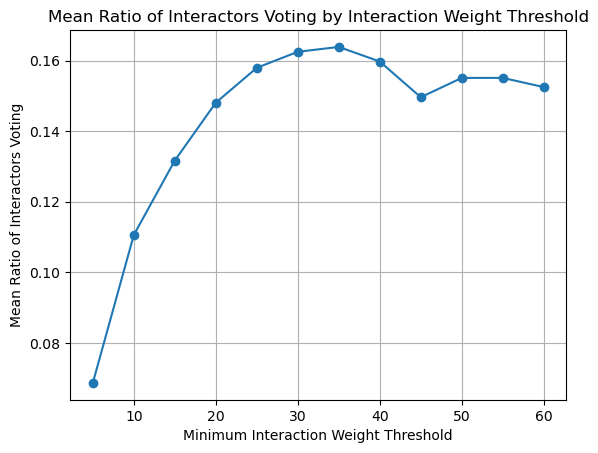

In [64]:
# Create different filters based on the weight column of edges_df
weight_thresholds = np.linspace(5, 60, num= 12, endpoint=True)
mean_ratios = []

for threshold in weight_thresholds:
    # Filter edges_df based on the current threshold
    filtered_edges_df = edges_df[edges_df['weight'] >= threshold]
    
    # Recompute the grouped_interactions DataFrame with the new filter
    filtered_grouped_interactions = filtered_edges_df.groupby('target').apply(
        lambda x: pd.Series({
            'number_of_distinct_interactions': filtered_edges_df[filtered_edges_df['target'] == x.name]['source'].nunique(),
            'number_interactors_voting': sum(filtered_edges_df[filtered_edges_df['target'] == x.name]['source'].isin(interactions_df[interactions_df['target'] == x.name]['source']))
        })
    ).reset_index()
    
    filtered_grouped_interactions['ratio_interactors_voting'] = filtered_grouped_interactions['number_interactors_voting'] / filtered_grouped_interactions['number_of_distinct_interactions']
    mean_ratio = filtered_grouped_interactions['ratio_interactors_voting'].mean()
    mean_ratios.append(mean_ratio)

# Plotting
plt.plot(weight_thresholds, mean_ratios, marker='o')
plt.xlabel('Minimum Interaction Weight Threshold')
plt.ylabel('Mean Ratio of Interactors Voting')
plt.title('Mean Ratio of Interactors Voting by Interaction Weight Threshold')
plt.grid(True)
plt.show()

There is a sharp increase in the mean ratio of interactors voting for the target as the minimum interaction weight threshold increases from the lowest value up to a certain point. This suggests that as you consider only those pairs with more significant interactions (a higher weight), there is a higher likelihood that they will participate in each other's elections. This part of the trend indicates a strong positive relationship between interaction intensity and voting participation.
The increasing trend in the ratio of voters plateaus, which may imply that beyond a certain point, increasing the threshold for interaction weight does not significantly influence the likelihood of users participating in each other's votes. It can be inferred that there might be a saturation point beyond which the strength of interaction (as quantified by weight) does not have much additional impact on voting participation.

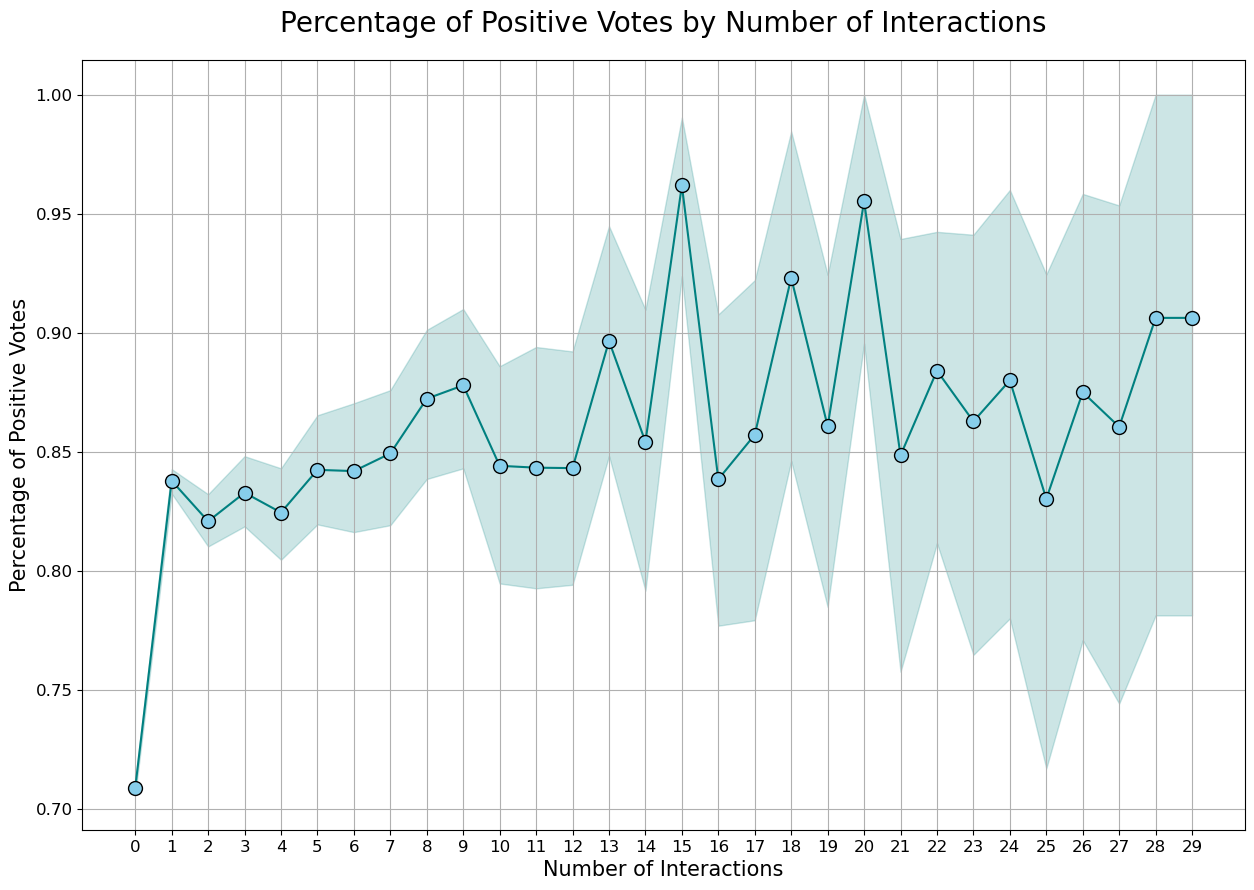

In [65]:
interaction_df_plot = interactions_df.copy()
interaction_df_plot.loc[interactions_df['vote'] != 1, 'vote'] = 0

interaction_count_counts = interaction_df_plot['interaction_count'].value_counts()
interaction_df_plot['count_per_interaction'] = interaction_df_plot['interaction_count'].map(interaction_count_counts)
filtered_df = interaction_df_plot[interaction_df_plot['count_per_interaction'] >= 30].copy()

plt.figure(figsize=(15, 10))
ax = sns.lineplot(x='interaction_count',
                  y='vote',
                  data=filtered_df,
                  color='teal',
                  marker='o',
                  markersize=10,
                  markerfacecolor='skyblue',
                  markeredgecolor='black',
                  markeredgewidth=1,
                  errorbar='ci')

ax.set_title('Percentage of Positive Votes by Number of Interactions', fontsize=20, pad=20)
ax.set_xlabel('Number of Interactions', fontsize=15)
ax.set_ylabel('Percentage of Positive Votes', fontsize=15)
ax.grid(True)  
ax.set_xticks(filtered_df['interaction_count'].unique()) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Despite the variability, there seems to be a general trend where the percentage of positive votes tends to increase with the number of interactions, especially noticeable in the initial section of the plot. However, this trend is not consistent across the entire range of interaction counts.

Here we will implement the logistic regression to analyse the factors that motivate participation following the method described in 1. 

In [66]:
#We compute for each voter the number of election he voted for, using elect_dynamics_df
elect_dynamics_df['number_of_elections_voted'] = elect_dynamics_df.groupby('source')['global_election_id'].transform('nunique')

elect_dynamics_df

,source,target,vote,result,year_election,date_vote,comment,global_election_id,vote_index_in_election,number_of_elections_voted
124379,Dbiv,(aeropagitica),1,1,2006,2006-02-28 00:09:00,"'''Support'''. Yippee, I get to be the first!",1,1,96
124380,King of Hearts,(aeropagitica),1,1,2006,2006-02-28 01:11:00,"'''Support''' as nominator, of course. --",1,2,270
124381,Blnguyen,(aeropagitica),1,1,2006,2006-02-28 01:32:00,"'''Support''' have seen this chap around, help...",1,3,369
124415,ILovePlankton,(aeropagitica),-1,1,2006,2006-02-28 02:05:00,'''Oppose''' Not enough interaction with other...,1,4,36
124382,Zsinj,(aeropagitica),1,1,2006,2006-02-28 02:50:00,"'''Support''', even though the majority of edi...",1,5,50
...,...,...,...,...,...,...,...,...,...,...
180516,mikkalai,Ђорђе Д. Божовић,-1,-1,2005,2005-11-27 17:16:00,'''Oppose''': The person is simply unknown to ...,4154,15,29
180517,Sarahe,Ђорђе Д. Божовић,-1,-1,2005,2005-11-28 00:05:00,"'''Oppose''' as per jkelly, JIP and Kelly Mart...",4154,16,21
180518,NormanEinstein,Ђорђе Д. Божовић,-1,-1,2005,2005-11-30 15:08:00,'''Oppose''' per JIP. --,4154,17,36
180504,Jobe6,Ђорђе Д. Божовић,1,-1,2005,2005-11-30 23:56:00,'''Support''' reasons for oppose are somewhat ...,4154,18,44


In [109]:
def get_number_of_contacts(voter, election, df, edges_df):
    list_contacts_voters = edges_df[edges_df['source'] == voter]['target'].values
    voter_vote_index = df[(df['source'] == voter) & (df['global_election_id'] == election)]['vote_index_in_election']
    
    if voter_vote_index.empty:
        number_of_contacts = 0
    else:
        number_of_contacts = df[(df['source'].isin(list_contacts_voters)) & 
                                (df['global_election_id'] == election) & 
                                (df['vote_index_in_election'] < voter_vote_index.values[0])
                               ]['source'].nunique()

    return number_of_contacts

In [110]:
def get_number_interactions (voter, target , edges_df) : 
    #check wether the voter and the target have interacted before
    if edges_df[(edges_df['source'] == voter ) & (edges_df['target'] == target)].empty : 
        return 0
    else : 
        return edges_df[(edges_df['source'] == voter) & (edges_df['target'] == target)]['weight'].values[0]

In [111]:
dataset = []

# Pre-compute the number of elections each voter has voted in
num_elections_voted = elect_dynamics_df.groupby('source')['global_election_id'].nunique()

# Iterate over each voter and election without nested loops
for (voter, election), group in elect_dynamics_df.groupby(['source', 'global_election_id']):
    # Check vote index condition
    if group['vote_index_in_election'].iloc[0] >= 2:
        
        # Get similar voters : same number of elections voted in and did not vote in the election
        num_elections_voter = group['number_of_elections_voted'].iloc[0]
        
        similar_voters = elect_dynamics_df[
            (elect_dynamics_df['number_of_elections_voted'] == num_elections_voter) &
            (elect_dynamics_df['source'] != voter) &
            (~elect_dynamics_df['global_election_id'].eq(election))
        ]['source'].unique()

        if len(similar_voters) > 0:

            #Choose a random voter from the similar voters
            similar_voter = np.random.choice(similar_voters)

            #Get the number of contacts from the voter who voted before the voter

            number_contacts_voter_voted_before = get_number_of_contacts(voter, election, elect_dynamics_df, edges_df)
            number_contacts_similar_voter_voted_before = get_number_of_contacts(similar_voter, election, elect_dynamics_df, edges_df)

            dataset.append({'voter': voter,
                            'voted': 1,
                            'number_of_contacts_voter': number_contacts_voter_voted_before - number_contacts_similar_voter_voted_before, 
                            'number_interactions_voter_candidate': get_number_interactions(voter, group['target'].values[0], edges_df),

                            })
            dataset.append({'voter': similar_voter,
                            'voted': 0,
                            'number_of_contacts_voter': number_contacts_similar_voter_voted_before - number_contacts_voter_voted_before , 
                            'number_interactions_voter_candidate': get_number_interactions(similar_voter, group['target'].values[0], edges_df)
                            })


KeyboardInterrupt: 

In [112]:
#create a dataframe from the list of dictionaries
dataset_df = pd.DataFrame(dataset)
dataset_df

,voter,voted,number_of_contacts_voter,number_interactions_voter_candidate
0,!---slappdash---!,1,0,0
1,Smitty494,0,0,0
2,%D0%90,1,0,0
3,Cymsdale,0,0,0
4,%D0%90,1,0,0
...,...,...,...,...
9124,Ajbpearce,1,0,0
9125,Netsnipe,0,0,0
9126,Ajbpearce,1,0,0
9127,NSR77,0,0,0


In [113]:
#Run a logistic regression on the dataset
mod = smf.logit(formula='voted ~ number_of_contacts_voter + number_interactions_voter_candidate', data=dataset_df)
res = mod.fit()
print(res.summary())


Optimization terminated successfully.
         Current function value: 0.595619
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  voted   No. Observations:                 9129
Model:                          Logit   Df Residuals:                     9126
Method:                           MLE   Df Model:                            2
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.1407
Time:                        19:18:51   Log-Likelihood:                -5437.4
converged:                       True   LL-Null:                       -6327.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.0098      0.023 

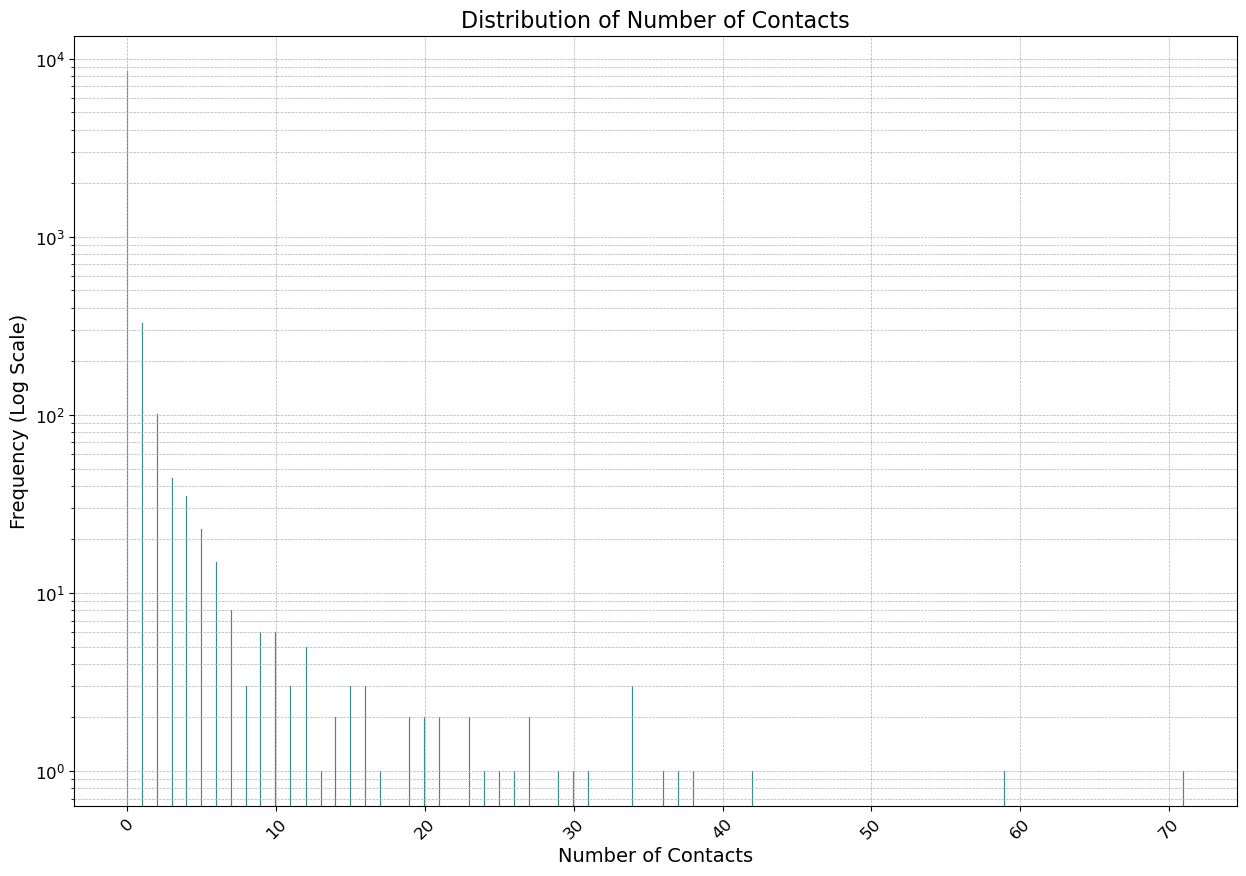

In [114]:
#Plot the distribution of the number of contacts per voter
plt.figure(figsize=(15, 10))

ax = sns.histplot(dataset_df['number_interactions_voter_candidate'], color='teal', log=True, bins=1000, edgecolor='black')

ax.set_title('Distribution of Number of Contacts', fontsize=16)
ax.set_xlabel('Number of Contacts', fontsize=14)
ax.set_ylabel('Frequency (Log Scale)', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

In [453]:
voters = analysis_df.groupby('source').apply(lambda x : pd.Series({
    'number_of_votes' : len(x['target'])})).reset_index()
voters[voters.source == 'Blnguyen']

,source,number_of_votes
1142,Blnguyen,372


To have a better understanding of the interactions, we plot them in a graph. We also plot the degree rank plot and histogram. The degree of a node is the number of edges adjacents to the node. This plot helps us to better understand the distribution of the number of adjacent nodes. We can see that most of the nodes have a low degree.

In [ ]:
# We sort the nodes in the graph by their degree
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
unique_degree, counts = np.unique(degree_sequence, return_counts=True)

# Degree histogram
plt.bar(unique_degree, counts,width=10, color='b')
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("# of Nodes")

plt.show()

### Communities <a class="anchor" id="communities_communities"></a>

We explore the relationship between users by creating communities. Communities are created using Louvain algorithm that "[works in 2 steps. On the first step it assigns every node to be in its own community and then for each node it tries to find the maximum positive modularity gain by moving each node to all of its neighbor communities. If no positive gain is achieved the node remains in its original community](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html)"

In [ ]:
#We create the communities

communities = nx.community.louvain_communities(G, resolution=1.5, seed=2)

In [ ]:
print(f"Number of communities in graph of users with interactions : {len(communities)}")

In [ ]:
for i, c in enumerate(communities):
    print(f"Community {i} has size {len(c)}")

### Vote analysis <a class="anchor" id="communities_vote"></a>

To understand the influence of communities, we compute the probability of vote to be within your community if it was voted at random.

In [ ]:
n = len(G) # Number of nodes in the graph
p_same_cluster = 0 # Probability that a random vote is an intra-cluster vote
array_p_same_cluster = np.array([])

# We compute the probability that a random vote is an intra-cluster vote
for c in communities:
    p_same_cluster += (len(c)/n)*((len(c)-1)/n)
    array_p_same_cluster = np.append(array_p_same_cluster, (len(c)/n)*((len(c)-1)/n))
print(f"Probability that a random vote is an intra-cluster vote in interaction graph : {p_same_cluster:.2%}")

In [ ]:
# Initialize a counter for votes within the same community
intra_vote_count = np.zeros(len(communities))

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the same community
    for count, community in enumerate(communities):
        if entity1 in community and entity2 in community:
            intra_vote_count[count] += 1

# Print the result
print(f"Number of votes within the same community : {int(intra_vote_count.sum())}")

In [ ]:
# Initialize a counter for votes in the graph
votes_in_the_graph = 0

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the graph
    if entity1 in G and entity2 in G:
        votes_in_the_graph += 1

# Print the result
print(f"Number of votes in the graph : {votes_in_the_graph}")

We compare the probability of a random vote with what was observed. The goal is to assess whether the users vote is influenced by its community. We observe that we have a ~3x increase in probability to vote towards your own community.

In [ ]:
print(f"Effective percentage of intra-cluster votes in G: {(intra_vote_count.sum()/votes_in_the_graph):.2%}")

To understand the increase in votes, we compute the expected number of votes if voted at random. Then we make the ratio to derive the multiplicative coefficient from the expected number of votes to observed. 

In [ ]:
# expected number of intra-cluster votes
expected_nb_votes = array_p_same_cluster * votes_in_the_graph

In [ ]:
# ratio of effective intra-cluster votes over expected intra-cluster votes
vote_gain = intra_vote_count / expected_nb_votes
vote_gain

We want to understand the distribution of votes between communities. For that we plot the distribution of votes between communities

In [ ]:
# Number of votes across communities
vote_count_matrix = np.zeros((len(communities), len(communities)))
nb_community_votes = np.zeros(len(communities))

In [ ]:
# Populate the vote count matrix
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        vote_count_matrix[i_src][i_dst] += 1
        nb_community_votes[i_src] += 1

In [ ]:
# We verify our computations and transform the vote count matrix into a ratio matrix
np.testing.assert_array_equal(vote_count_matrix.sum(axis=1), nb_community_votes)
ratio_vote_count_matrix = (vote_count_matrix / nb_community_votes[:, np.newaxis])*100 
np.testing.assert_almost_equal(ratio_vote_count_matrix.sum(axis=1), np.ones(len(communities))*100)

In the plot we observe that the destination communities that recieve most of the votes are the larger communities. This is explained by the fact that for large communities, more votation take place and therefore more votes are directed to them.

In [ ]:
# Heatmap of the ratio of votes across communities
plt.figure(figsize=(24, 12))
sns.heatmap(ratio_vote_count_matrix, cmap="Blues", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

To mitigate this domination of the large communities, we scale the results by the probability of a vote between two communities given that the votes are random. We display the ratio of effective votes over expected votes for each pair of communities.

In [ ]:
# Create matrix that represents the probability of a vote between two communities
prob_vote_community_matrix = np.zeros((len(communities), len(communities)))
for i_src in range(len(communities)):
    for i_dst in range(len(communities)):
        prob_vote_community_matrix[i_src][i_dst] = (len(communities[i_src])*len(communities[i_dst]))/(len(G)**2)
# create matrix that represents the expected number of votes between two communities
ratio_vote_expected_matrix = prob_vote_community_matrix * votes_in_the_graph

In [ ]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [ ]:
gain_vote_expected_matrix = np.nan_to_num(nb_result_votes / ratio_vote_expected_matrix)

In [ ]:
# Heatmap of the gain from expected votes across communities
# Couleurs sympas: 'PuBuGn', 'RdYlBu', 'coolwarm'
plt.figure(figsize=(36, 12))
sns.heatmap(gain_vote_expected_matrix, cmap='PuBuGn', annot=True, fmt=".2f", linewidths=.5, linecolor="black")
plt.title("Multiplicative relation expected number of votes to observed number of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

The diagonal of the matrix has significantly higher values. This indicates that people tend to vote more for the people part of their community. We recall that the communities have been created with the interactions between the users and not the votes.

#### Can we find a rivalry between some communities? Maybe a community only vote negatively towards another community.

We want to know the voting habitudes of communities. For that we plot the result precentage per community

In [ ]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [ ]:
perc_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100

In [ ]:
for_ratio_result_matrix = perc_result_matrix[:,:,2]
significance_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
for i in range(len(communities)):
    for j in range(len(communities)):
        significance_matrix[i][j][0] = stats.binom_test(vote_result_matrix[i][j][2], 
                                                     n=nb_result_votes[i][j], 
                                                     p=value_perc_vote[1]/100)
plt.figure(figsize=(36, 12))
sns.heatmap(for_ratio_result_matrix, cmap="Greens", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
for i in range(len(communities)):
    for j in range(len(communities)):
        if significance_matrix[i][j][0] < 0.05:
            plt.scatter(j+0.85, i+0.35, color='black', marker='*')
plt.title("Percentage of votes \"for\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

In [ ]:
neutral_ratio_result_matrix = perc_result_matrix[:,:,1]
for i in range(len(communities)):
    for j in range(len(communities)):
        significance_matrix[i][j][1] = stats.binom_test(vote_result_matrix[i][j][1], 
                                                     n=nb_result_votes[i][j], 
                                                     p=value_perc_vote[0]/100)
plt.figure(figsize=(36, 12))
sns.heatmap(neutral_ratio_result_matrix, cmap="Greys", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
for i in range(len(communities)):
    for j in range(len(communities)):
        if significance_matrix[i][j][1] < 0.05:
            plt.scatter(j+0.85, i+0.35, color='black', marker='*')
plt.title("Percentage of votes \"neutral\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

In [ ]:
against_ratio_result_matrix = perc_result_matrix[:,:,0]
for i in range(len(communities)):
    for j in range(len(communities)):
        significance_matrix[i][j][2] = stats.binom_test(vote_result_matrix[i][j][0], 
                                                     n=nb_result_votes[i][j], 
                                                     p=value_perc_vote[-1]/100)
plt.figure(figsize=(36, 12))
sns.heatmap(against_ratio_result_matrix, cmap="Reds", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
for i in range(len(communities)):
    for j in range(len(communities)):
        if significance_matrix[i][j][2] < 0.05:
            plt.scatter(j+0.85, i+0.35, color='black', marker='*')
plt.title("Percentage of votes \"against\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

In [ ]:
size_plot = len(communities)
fig, ax = plt.subplots(figsize=(size_plot, size_plot), nrows=len(communities), ncols=len(communities), layout='constrained')
for i in range(len(communities)):
    for j in range(len(communities)):
        diff_for = perc_result_matrix[i][j][2] - value_perc_vote[1]
        diff_neutral = perc_result_matrix[i][j][1] - value_perc_vote[0]
        diff_against = perc_result_matrix[i][j][0] - value_perc_vote[-1]
        ax[i,j].bar(x=['for', 'neutral', 'against'], height=[diff_for, diff_neutral, diff_against], color=['green', 'grey', 'red'])
        ax[i,j].set_xticks([])
        ax[i,j].set_ylim(-70, 70)
        for k in range(3):
            if significance_matrix[i][j][k] < 0.05:
                ax[i,j].scatter(x=[k], y=[60], marker='*', color='black')

for i, ax in enumerate(fig.get_axes()):
    if i < len(communities):
        ax.set_xlabel(f'{i%len(communities)}', size='large', fontweight='bold') 
        ax.xaxis.set_label_position('top')
    if i%len(communities) == 0 :
        ax.set_ylabel(f'{i//len(communities)}', size='large', fontweight='bold')
    else :
        ax.label_outer()
    if i//len(communities) == len(communities)-1:
        ax.set_xlabel(f'{i%len(communities)}', size='large', fontweight='bold') 
fig.suptitle("Difference between observed and mean percentage of votes per communities in G", size='x-large', fontweight='bold')
fig.supxlabel("Destination community", size='x-large', fontweight='bold')
fig.supylabel("Source community", size='x-large', fontweight='bold')
plt.show()
        

We can observe that some communities display either a positive or negative bias in their voting preferences. If votes were at random and participation uniform accross communities, we would have expected that the portion of votes "for", "against" and "neutral" to have to same proportion between communities. Suspicious results could help us to inspect further the relationship between the two communities involved.

# Content of edits analysis <a class="anchor" id="edits"></a>

This section explores the relationship between the topics of Wikipedia pages edited by users and the occurrence of votes between two users. The goal is to identify potential correlations and patterns that would show that editing similar topics has an influence in the motivation to cast a vote.

### Setup <a class="anchor" id="edits_setup"></a>

In [ ]:
# The original dataset can be found here (https://snap.stanford.edu/data/wiki-meta.html). 
# The version that we use here has already been modified so that we get each user and 
# the page they modified with the number of edits

edits_df = pd.read_csv("../data/interactions_edits_grouped.zip", index_col=0, compression='zip')
edits_df

In [ ]:
# We create a list of Wikipedia pages modified by each users
user_indices = edits_df.groupby('username').apply(lambda x: x.index.tolist()).reset_index(name='Indices')
user_indices

In [ ]:
# Create a list of all users present in the edits dataset
users = set(edits_df['username'].tolist())

Create a matrix with the Jaccard index (on the the lists of modified pages) for all pairs of users. Jaccard index "[is a statistic used for gauging the similarity and diversity of sample sets](https://en.wikipedia.org/wiki/Jaccard_index)". It will be used to understand the similarity of edited pages between pairs of users.

In [ ]:
matrix_similarity = pd.read_csv("../data/jaccard.csv.zip", index_col=0, compression='zip')
matrix_similarity

Create a DataFrame with all pairs of users and a binary variable that indicates if a vote exists for each pair. It will be helpful to computes the correlation between similarity in edited pages and voting interaction between two users.

In [ ]:
similarity_and_vote = pd.read_csv("../data/jaccard_and_votes.csv.zip", index_col=0, compression='zip')
similarity_and_vote

### Statistics <a class="anchor" id="edits_statistics"></a>

Now we will compute some statistics on this data.

In [ ]:
pearsonr(similarity_and_vote['vote'], similarity_and_vote['jaccard'])

The correlation between similarity score on edited pages and the votes is not very strong but positive with high significance.

In [ ]:
# Mean similarity between all pairs of users
mean_sim_all = similarity_and_vote['jaccard'].mean()
mean_sim_all

In [ ]:
# Mean similarity between pairs of users that are linked by a vote
mean_sim_vote = similarity_and_vote[similarity_and_vote['vote'] == 1]['jaccard'].mean()
mean_sim_vote

In [ ]:
print(f"People that are linked by a vote have {mean_sim_vote / mean_sim_all:.2f} "
      f"times more common edited pages than the average.")

### Investigation of most edited pages <a class="anchor" id="edits_investigation"></a>

We investigate most edited pages per community. The goal is to find a common topic that could define community's interest.

In [ ]:
for count, community in enumerate(communities):
    community_to_check = community
    
    user_list = list(user_indices['username'])
    all_subject = set()
    for user in community_to_check:
        if user in user_list:
            all_subject = (set(user_indices[user_indices['username'] == user]['Indices'].iloc[0])
                           .union(all_subject))
            
    data = pd.DataFrame(index=list(all_subject), columns=['count'])
    data = data.fillna(0)
    
    for user in community_to_check:
        if user in user_list:
            subjects = user_indices[user_indices['username'] == user]['Indices'].iloc[0]
            for s in subjects:
                data.at[s, 'count'] += 1
    print(f"\nCommunity {count}:")            
    print(data.sort_values('count', ascending = False).head(20))